<a href="https://colab.research.google.com/github/fabiansep/TalentOps/blob/main/m2_e13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generando datos simulados...
Datos creados: 300 clientes en 5 canales.
--------------------------------------------------

[PASO 2] VERIFICACIÓN DE ASUNCIONES
-> Normalidad (Shapiro-Wilk):
   Redes Sociales: p=0.527
   Búsqueda Orgánica: p=0.257
   Email Marketing: p=0.171
   Publicidad Paga: p=0.513
   Referidos: p=0.598
-> Homocedasticidad (Levene): p=0.000
   CONCLUSIÓN: Varianzas DISTINTAS (Se requiere Welch ANOVA).

[PASO 3] RESULTADOS ANOVA
Test utilizado: Welch ANOVA (Robusto)
Estadístico F: 30.451
Valor p: 5.8014e-17
CONCLUSIÓN: RECHAZAMOS H0. Existen diferencias significativas entre canales.

[PASO 4] PRUEBAS POST-HOC
Canal A              | Canal B              | Diferencia | p-adj   
----------------------------------------------------------------------
Redes Sociales       | Búsqueda Orgánica    | -83.38     | 0.0025
Redes Sociales       | Email Marketing      | -261.52    | 0.0000
Redes Sociales       | Publicidad Paga      | -116.11    | 0.0009
Redes Sociales       | Refer

/tmp/ipython-input-2189009128.py:150: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([grupos_clv[c] for c in canales], labels=canales, patch_artist=True)


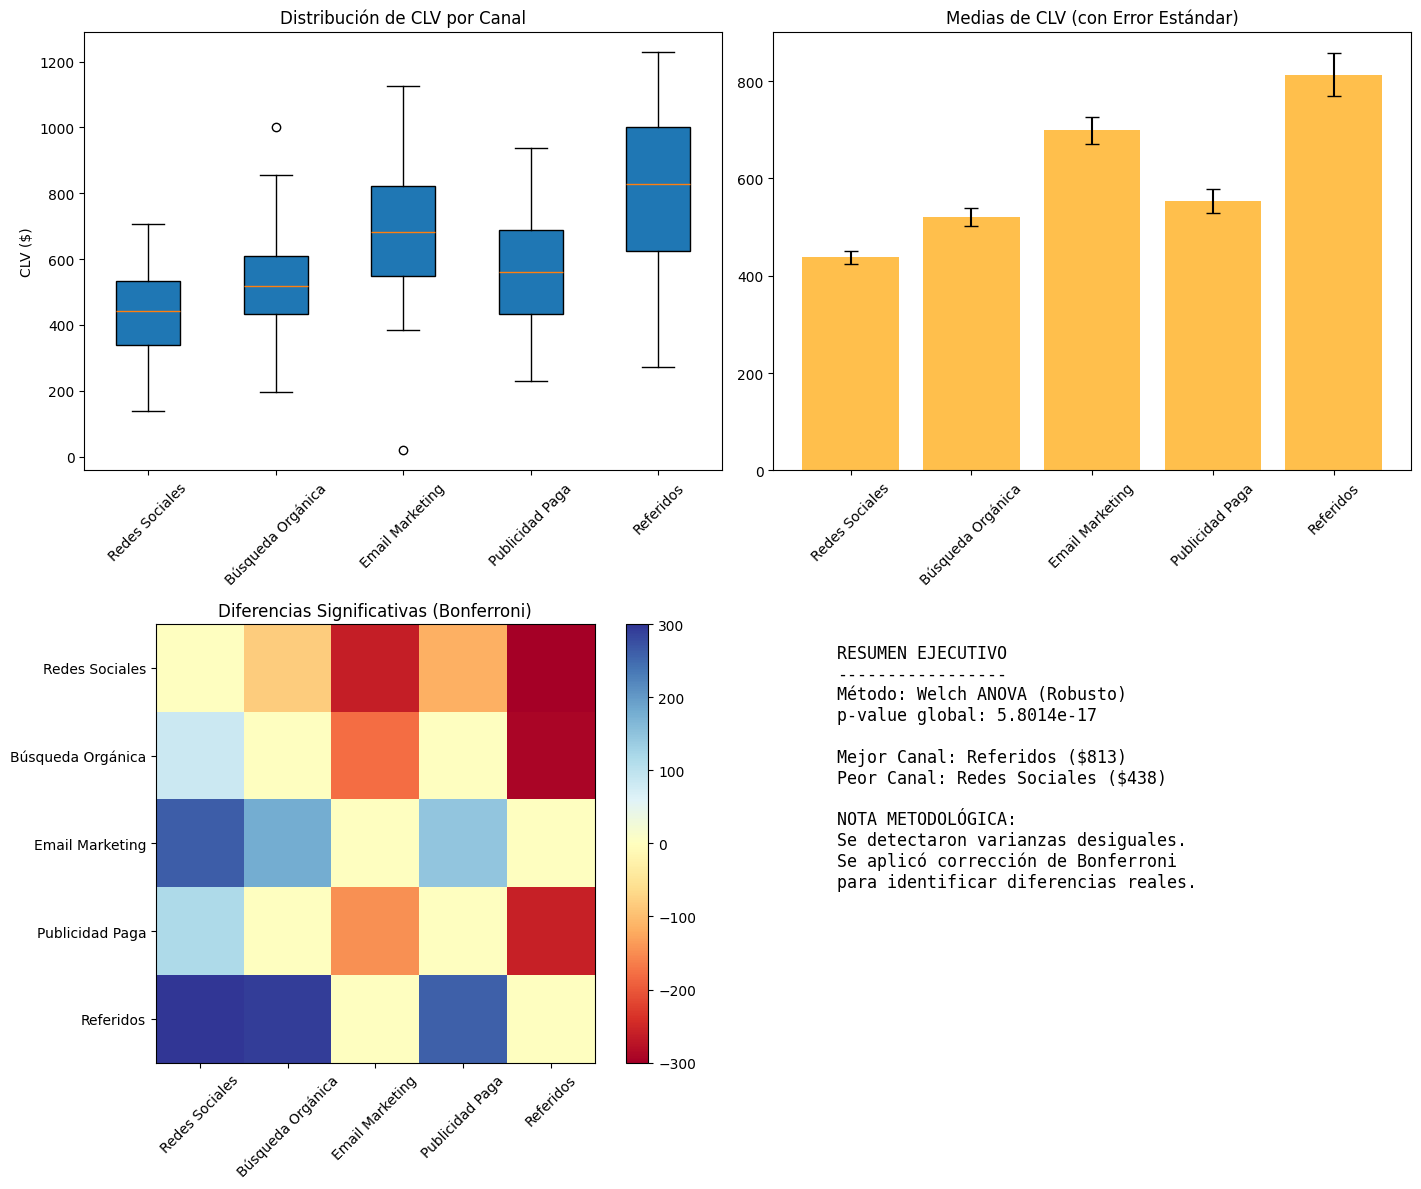

Análisis finalizado.


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.multitest import multipletests
from itertools import combinations
import matplotlib.pyplot as plt

# ==========================================
# 1. PREPARACIÓN DE DATOS Y CONFIGURACIÓN
# ==========================================
print("Generando datos simulados...")
np.random.seed(42)
n_clientes = 300

# Definir canales y sus pesos (Muestras desbalanceadas)
canales = ['Redes Sociales', 'Búsqueda Orgánica', 'Email Marketing', 'Publicidad Paga', 'Referidos']
pesos_canales = [0.3, 0.25, 0.2, 0.15, 0.1]

# Asignar canales
canal_asignado = np.random.choice(canales, n_clientes, p=pesos_canales)

# Definir distribuciones de CLV (Varianzas desiguales intencionales)
clv_por_canal = {
    'Redes Sociales': 450,
    'Búsqueda Orgánica': 520,
    'Email Marketing': 680,
    'Publicidad Paga': 590,
    'Referidos': 750
}

# Generar datos con variabilidad dependiente de la media (Heterocedasticidad)
clv_data = []
for canal in canal_asignado:
    media = clv_por_canal[canal]
    valor = np.random.normal(media, media * 0.3)
    clv_data.append(max(0, valor))

# Crear DataFrame
df = pd.DataFrame({
    'cliente_id': range(1, n_clientes + 1),
    'canal_adquisicion': canal_asignado,
    'clv': clv_data
})

print(f"Datos creados: {len(df)} clientes en {len(canales)} canales.")
print("-" * 50)

# ==========================================
# 2. VERIFICACIÓN DE ASUNCIONES
# ==========================================
print("\n[PASO 2] VERIFICACIÓN DE ASUNCIONES")

# Agrupar datos para facilitar el acceso
grupos_clv = {canal: df[df['canal_adquisicion'] == canal]['clv'].values for canal in canales}

# a) Normalidad (Shapiro-Wilk)
print("-> Normalidad (Shapiro-Wilk):")
for canal, datos in grupos_clv.items():
    stat, p = stats.shapiro(datos)
    print(f"   {canal}: p={p:.3f}")

# b) Homocedasticidad (Levene)
stat, p_levene = stats.levene(*grupos_clv.values())
homocedasticidad = p_levene > 0.05
print(f"-> Homocedasticidad (Levene): p={p_levene:.3f}")
if homocedasticidad:
    print("   CONCLUSIÓN: Varianzas iguales (Se podría usar ANOVA estándar).")
else:
    print("   CONCLUSIÓN: Varianzas DISTINTAS (Se requiere Welch ANOVA).")

# ==========================================
# 3. EJECUCIÓN DEL ANOVA (ADAPTATIVO)
# ==========================================
print("\n[PASO 3] RESULTADOS ANOVA")

if homocedasticidad:
    # Si las varianzas fueran iguales (raro en datos reales de negocio)
    f_stat, p_value = stats.f_oneway(*grupos_clv.values())
    tipo_test = "ANOVA Estándar"
else:
    # CAMINO ROBUSTO (El que se ejecutará con estos datos)
    # anova_oneway con use_var='unequal' es el Test de Welch
    resultado = anova_oneway(df['clv'], df['canal_adquisicion'], use_var='unequal')
    f_stat = resultado.statistic
    p_value = resultado.pvalue
    tipo_test = "Welch ANOVA (Robusto)"

print(f"Test utilizado: {tipo_test}")
print(f"Estadístico F: {f_stat:.3f}")
print(f"Valor p: {p_value:.4e}")

if p_value < 0.05:
    print("CONCLUSIÓN: RECHAZAMOS H0. Existen diferencias significativas entre canales.")
else:
    print("CONCLUSIÓN: NO rechazamos H0.")

# ==========================================
# 4. PRUEBAS POST-HOC (WELCH T-TEST + BONFERRONI)
# ==========================================
print("\n[PASO 4] PRUEBAS POST-HOC")

# Generamos todas las combinaciones de pares
pares = list(combinations(canales, 2))
p_values_raw = []
info_pares = []

# Calculamos T-test de Welch para cada par
for (g1, g2) in pares:
    datos_g1 = grupos_clv[g1]
    datos_g2 = grupos_clv[g2]

    # equal_var=False es fundamental aquí
    t, p = stats.ttest_ind(datos_g1, datos_g2, equal_var=False)

    p_values_raw.append(p)
    info_pares.append({
        'A': g1,
        'B': g2,
        'diff': np.mean(datos_g1) - np.mean(datos_g2)
    })

# Aplicamos corrección de Bonferroni (Task 3 de tu teoría)
reject, p_adjusted, _, _ = multipletests(p_values_raw, alpha=0.05, method='bonferroni')

# Guardamos resultados significativos
resultados_significativos = []
print(f"{'Canal A':<20} | {'Canal B':<20} | {'Diferencia':<10} | {'p-adj':<8}")
print("-" * 70)

for i, row in enumerate(info_pares):
    if reject[i]: # Si es significativo tras la corrección
        print(f"{row['A']:<20} | {row['B']:<20} | {row['diff']:<10.2f} | {p_adjusted[i]:.4f}")
        res_row = row.copy()
        res_row['p_adj'] = p_adjusted[i]
        resultados_significativos.append(res_row)

df_posthoc = pd.DataFrame(resultados_significativos)

# ==========================================
# 5. VISUALIZACIÓN
# ==========================================
print("\n[PASO 5] GENERANDO GRÁFICOS...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
((ax1, ax2), (ax3, ax4)) = axes

# A) Boxplot
ax1.boxplot([grupos_clv[c] for c in canales], labels=canales, patch_artist=True)
ax1.set_title('Distribución de CLV por Canal')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('CLV ($)')

# B) Barplot de Medias + Error Estándar
medias = [np.mean(g) for g in grupos_clv.values()]
errores = [stats.sem(g) for g in grupos_clv.values()]
ax2.bar(canales, medias, yerr=errores, capsize=5, color='orange', alpha=0.7)
ax2.set_title('Medias de CLV (con Error Estándar)')
ax2.tick_params(axis='x', rotation=45)

# C) Heatmap de Diferencias (Basado en Bonferroni)
matriz_diff = np.zeros((len(canales), len(canales)))

if not df_posthoc.empty:
    for _, row in df_posthoc.iterrows():
        try:
            i = canales.index(row['A'])
            j = canales.index(row['B'])
            matriz_diff[i, j] = row['diff']
            matriz_diff[j, i] = -row['diff']
        except: pass

im = ax3.imshow(matriz_diff, cmap='RdYlBu', vmin=-300, vmax=300)
ax3.set_xticks(range(len(canales)))
ax3.set_yticks(range(len(canales)))
ax3.set_xticklabels(canales, rotation=45)
ax3.set_yticklabels(canales)
ax3.set_title('Diferencias Significativas (Bonferroni)')
plt.colorbar(im, ax=ax3)

# D) Resumen Textual
ax4.axis('off')
mejor_canal = canales[np.argmax(medias)]
peor_canal = canales[np.argmin(medias)]

texto_resumen = (
    f"RESUMEN EJECUTIVO\n"
    f"-----------------\n"
    f"Método: {tipo_test}\n"
    f"p-value global: {p_value:.4e}\n\n"
    f"Mejor Canal: {mejor_canal} (${max(medias):.0f})\n"
    f"Peor Canal: {peor_canal} (${min(medias):.0f})\n\n"
    f"NOTA METODOLÓGICA:\n"
    f"Se detectaron varianzas desiguales.\n"
    f"Se aplicó corrección de Bonferroni\n"
    f"para identificar diferencias reales."
)
ax4.text(0.1, 0.4, texto_resumen, fontsize=12, family='monospace')

plt.tight_layout()
plt.show()
print("Análisis finalizado.")